<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Linearity Ramp Corrected Residuals

### Table of Contents
<div style="text-align: left"> 

<br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [Run Linearity Pipeline Step](#pipeline_ID) <br> [Calculate Residuals and Display](#residual_ID) <br> 

</div>

<a id="intro_ID"></a>
# Introduction

The linearity step applies the “classic” linearity correction adapted from the HST WFC3/IR linearity correction routine, correcting science data values for detector non-linearity. The correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure. 

For more details, visit the documentation here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html


### Defining Term

JWST: James Webb Space Telescope

OUT: Other Useful Terms

[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports

* astropy.io for opening fits files
* ci_watson.artifactory_helpers.get_bigdata for data retrieval
* jwst.datamodels for building model for JWST Pipeline
* jwst.linearity.LinearityStep to perform the linearity pipeline correction
* matplotlib.pyplot.plt to generate plot
* numpy for array parsing and masking
* os for operating system commands.

* matplotlib inline for plot rendering in notebook

[Top of Page](#title_ID)

In [1]:
%matplotlib inline
from astropy.io import fits
from ci_watson.artifactory_helpers import get_bigdata
from jwst.datamodels import MIRIRampModel
from jwst.linearity import LinearityStep
import matplotlib.pyplot as plt
import numpy as np
import os

<a id="data_ID"></a>
# Getting the Data

The data we are using for this test is an uncalibrated MIRI image from cryovac testing. List other interesting features about why this dataset was chosen for testing.

Mention something about artifactory... Or how or where we store and access data.

[Top of Page](#title_ID)

In [2]:
filename = get_bigdata('jwst_validation_notebooks',
                       'validation_data.zip!',
                       'validation_data',
                       'linearity',
                       'jwst_linearity_validation_test',
                       'jw80600003001_02101_00001_mirimage_uncal.fits')
fits_input = fits.open(filename)

<a id="pipeline_ID"></a>
# Run Linearity Pipeline Step

Define the output file and run the linearity correction step of the pipeline.

[Top of Page](#title_ID)

In [3]:
outname = fits_input[0].header['filename'].replace('.fits',
                                                    '_linearitystep.fits')
LinearityStep.call(MIRIRampModel(fits_input), output_file=outname,
                   save_results=True)

2020-04-20 16:10:46,523 - stpipe - WARNING - /srv/jenkins/workspace/Notebooks/jwst_validation_notebooks/miniconda3/envs/jwst_validation_notebooks/lib/python3.7/site-packages/jwst/datamodels/ramp.py:51: DeprecationWarning: MIRIRampModel is deprecated and will be removed.  Use RampModel.
  "Use RampModel.", category=DeprecationWarning)



2020-04-20 16:10:48,226 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   Unknown reference type 'pars-linearitystep'


2020-04-20 16:10:48,231 - stpipe.LinearityStep - INFO - LinearityStep instance created.


2020-04-20 16:10:48,283 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(30, 100, 128, 136) from jw80600003001_02101_00001_mirimage_uncal.fits>,).


2020-04-20 16:10:48,285 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/srv/jenkins/workspace/Notebooks/jwst_validation_notebooks/jwst_validation_notebooks/linearity/jwst_linearity_residuals_test/jw80600003001_02101_00001_mirimage_uncal_linearitystep.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2020-04-20 16:10:48,308 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits   46.5 M bytes  (1 / 1 files) (0 / 46.5 M bytes)


2020-04-20 16:10:49,537 - stpipe.LinearityStep - INFO - Using Linearity reference file /tmp/crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2020-04-20 16:10:50,391 - stpipe.LinearityStep - INFO - Extracting linearity subarray to match science data


2020-04-20 16:10:51,528 - stpipe.LinearityStep - INFO - Saved model in jw80600003001_02101_00001_mirimage_uncal_linearitystep.fits


2020-04-20 16:10:51,529 - stpipe.LinearityStep - INFO - Step LinearityStep done


<RampModel(30, 100, 128, 136) from jw80600003001_02101_00001_mirimage_uncal_linearitystep.fits>

<a id="residual_ID"></a>
# Calculate Residuals and Display

Calculate the second difference of the linearity corrected ramp for each 
pixel. If the ramp is perfectly linear they should be zero.

[Top of Page](#title_ID)

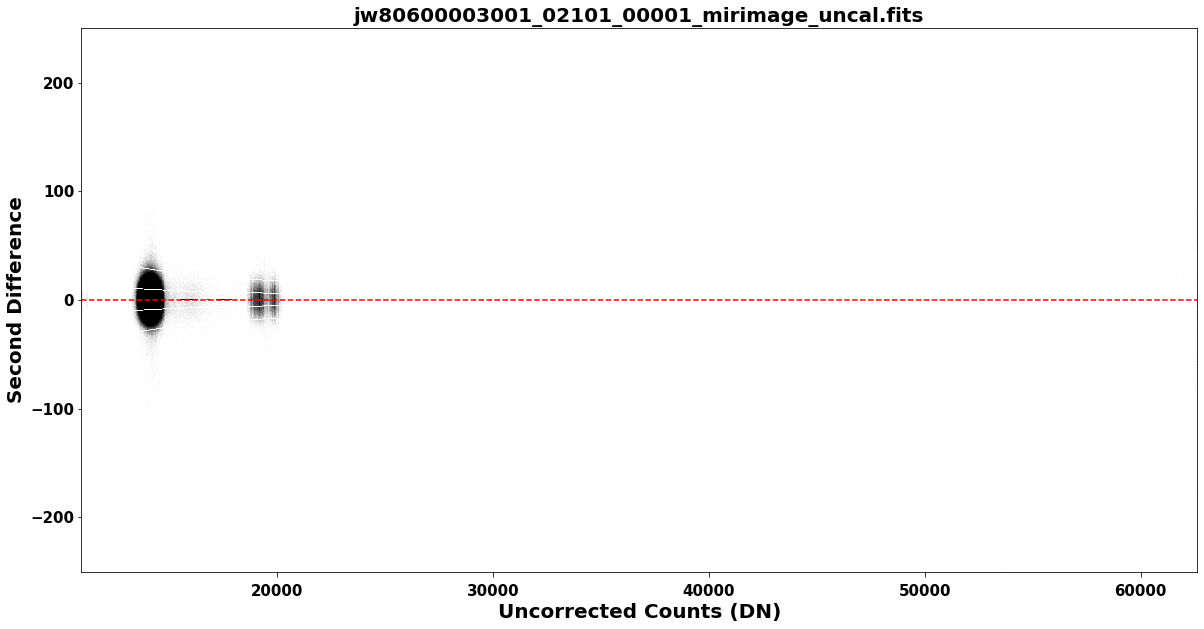

In [4]:
fits_output = fits.open(outname)

nints, ngroups, nx, ny = fits_output['SCI'].data.shape
data_by_pixel = fits_output['SCI'].data.reshape(nints, ngroups, nx * ny)
groupdq_by_pixel = fits_output['GROUPDQ'].data.reshape(nints, ngroups,
                                                       nx * ny)
masked_output = np.ma.array(data_by_pixel, mask=groupdq_by_pixel.astype(bool))
masked_input = np.ma.array(fits_input['SCI'].data.reshape(nints, ngroups, nx * ny),
                           mask=groupdq_by_pixel.astype(bool))
second_diff = np.ma.diff(masked_output, n=2, axis=1)

# Set plot params
plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.figure(figsize=(20,10))
plt.title(fits_input[0].header['FILENAME'], fontsize=20, fontweight='bold')

plt.plot(masked_input.data[0, 1:-1, :].flatten(),
         second_diff.data[0, :, :].flatten(), ',k', alpha=.01)

plt.axhline(y=0.0, color='r', ls='--')

plt.xlim(min(masked_input.data[0, 1:-1, :].flatten()), max(masked_input.data[0, 1:-1, :].flatten()))
plt.ylim(-250, 250)
plt.ylabel('Second Difference', fontsize=20, fontweight='bold')
plt.xlabel('Uncorrected Counts (DN)', fontsize=20, fontweight='bold')

plt.show()

<a id="about_ID"></a>
## About this Notebook
**Author:** Mees Fix, RIA MESA Branch
<br>**Updated On:** 04/19/2019

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 